In [2]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
driver = webdriver.Chrome('/usr/local/bin/chromedriver')
driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p434')


In [5]:
#Creating empty data frame to store user_id, dates and comments from ~5K users.
comments = pd.DataFrame(columns = ['Date','user_id','comments'])

j = 434
while (j>=1):
    # Running while loop only till we get 5K comments 
    if (len(comments)<5000):
        url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(j)
        driver.get(url)
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
            
            userid = userid_element.text
            
           
            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
                    
            comment = user_message.text
            
            #Extracting Block Quote if Present
            block_quote = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
            block_quote_class = block_quote.find_elements_by_class_name('UserQuote')
            block_text = ''
            if len(block_quote_class)>0:
                block_text = block_quote_class[0].text
            
            #Replacing block quotes
            comment = comment.replace(block_text,"")
            
           #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]
        j=j-1
    else:
        break        

KeyboardInterrupt: 

In [13]:
import copy
copy_comments = copy.deepcopy(comments)

def delete_space(s):
    return s.replace("\n"," ")

copy_comments['comments'] = copy_comments['comments'].apply(delete_space)
copy_comments.to_csv('edmund_comments.csv', header=True, sep=',') 

In [6]:
copy_comments = pd.read_csv('edmund_comments.csv')
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')
copy_comments = copy_comments.dropna()
copy_comments.reset_index(inplace  = True)

In [7]:
def remove_punctuation(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

def conv_lowercase(x):
    return x.lower()

copy_comments['comments_clean'] = copy_comments['comments'].apply(remove_punctuation).apply(conv_lowercase)
models['brand'] = models['brand'].apply(remove_punctuation)

In [8]:
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
copy_comments['model_to_brand'] = copy_comments['comments_clean'].apply(model_to_brand)

In [9]:
copy_comments.head()

,index,Unnamed: 0,Date,user_id,comments,comments_clean,model_to_brand
0,0,0,"August 18, 2019 8:19PM",andres3,The leather is definitely more Audi-like tha...,the leather is definitely more audilike than j...,the leather is definitely more audilike than v...
1,1,1,"August 18, 2019 8:45PM",dino001,It just made my next car list. Looks very much...,it just made my next car list looks very much ...,it just made my next car ltoyota looks very mu...
2,2,2,"August 18, 2019 8:55PM",Michaell,The 6/72 warranty is over with the 2019 model...,the 672 warranty is over with the 2019 model year,the 672 warranty is over with the 2019 model year
3,3,3,"August 18, 2019 9:09PM",dino001,You mean 2019 is the last year? That’s a bumme...,you mean 2019 is the last year that’s a bummer...,you mean 2019 is the last year that’s a bummer...
4,4,4,"August 18, 2019 10:17PM",sda,"4 yr/50k, same as Audi. From what I read deal...",4 yr50k same as audi from what i read dealers ...,4 yr50k same as audi from what i read dealers ...


In [10]:
copy_comments['tokenize_comments'] = copy_comments['model_to_brand'].apply(word_tokenize).apply(set).apply(list)

# Remove stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
copy_comments['final_list'] =  copy_comments['tokenize_comments'].apply(remove_stopwords)
#filtered_sentence = [w for w in temp['tokenize_comments'] if not w in stop_words]

In [11]:
# Creating a list of all the words in the comments to count word frequency in the next step

count = []
for i in range(len(copy_comments)):
    count+=copy_comments['final_list'][i]
    
# count

In [12]:
# fetching the frequency of words
from nltk import FreqDist
word_freq = nltk.FreqDist(count)
word_freq

FreqDist({'car': 1858, 'like': 1149, 'one': 1051, 'bmw': 1025, 'would': 1009, 'get': 890, 'think': 843, 'new': 829, 'audi': 777, 'dont': 730, ...})

In [13]:
# fetching unique brands
brands_unique = models['brand'].drop_duplicates().tolist()
brands_unique

['acura',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'car',
 'chevrolet',
 'chrysler',
 'dodge',
 'ford',
 'honda',
 'hyndai kia',
 'hyundai',
 'infiniti',
 'kia',
 'lincoln',
 'mazda',
 'mercedes',
 'mercedes benz',
 'mercedesbenz',
 'mercury',
 'mitsubishi',
 'nissan',
 'pontiac',
 'problem',
 'saturn',
 'seat',
 'sedan',
 'subaru',
 'suzuki',
 'toyata',
 'toyota',
 'volkswagen',
 'volkwagen',
 'volvo']

In [14]:
top_words = word_freq.most_common(500)
top_brands = []
for (key, items) in top_words:
    if key in brands_unique:
        brand_count = (key,items)
        top_brands.append(brand_count)   
        
top_brands

[('car', 1858),
 ('bmw', 1025),
 ('audi', 777),
 ('acura', 491),
 ('honda', 407),
 ('seat', 267),
 ('sedan', 241),
 ('volkswagen', 234),
 ('problem', 214),
 ('cadillac', 206),
 ('mercedesbenz', 189),
 ('toyota', 184),
 ('hyundai', 182),
 ('infiniti', 177),
 ('ford', 171),
 ('volvo', 134),
 ('chevrolet', 117),
 ('kia', 110),
 ('subaru', 94),
 ('buick', 84),
 ('mazda', 78)]

In [15]:
top_10_brands_count = top_brands[:14]
print ('Below list contains the top 10 brands along with their frequencies\n' , top_10_brands_count[:14])
#there are a few entries on top that are not brands and hence we can discard those values e.g. car, sedan, problem, seat
#so the final top 10 brands are given as :
top_10_brands_list=[]
for i in range(len(top_10_brands_count)):
    if(top_10_brands_count[i][0] not in ['car','sedan','seat','problem']):
        top_10_brands_list.append(top_10_brands_count[i][0])
   
    
print('\n\nFinal list of top 10 brands -\n ',top_10_brands_list);


Below list contains the top 10 brands along with their frequencies
 [('car', 1858), ('bmw', 1025), ('audi', 777), ('acura', 491), ('honda', 407), ('seat', 267), ('sedan', 241), ('volkswagen', 234), ('problem', 214), ('cadillac', 206), ('mercedesbenz', 189), ('toyota', 184), ('hyundai', 182), ('infiniti', 177)]


Final list of top 10 brands -
  ['bmw', 'audi', 'acura', 'honda', 'volkswagen', 'cadillac', 'mercedesbenz', 'toyota', 'hyundai', 'infiniti']


### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 


In [16]:
# the top 10 brands.
  
    
top_10_brands_list

['bmw',
 'audi',
 'acura',
 'honda',
 'volkswagen',
 'cadillac',
 'mercedesbenz',
 'toyota',
 'hyundai',
 'infiniti']

In [17]:
df = pd.DataFrame(columns = top_10_brands_list)

def brand_mentioned(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_10_brands_list:
    df[brand] = copy_comments['final_list'].apply(brand_mentioned)    

In [18]:
df.head()

,bmw,audi,acura,honda,volkswagen,cadillac,mercedesbenz,toyota,hyundai,infiniti
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [19]:
# Calculating lift among top brands
df2=pd.DataFrame(columns = top_10_brands_list)
for i in range(len(top_10_brands_list)):
    new_list = []
    for j in range(len(top_10_brands_list)):
        if (i!=j):
            numerator = ((df[top_10_brands_list[i]] + df[top_10_brands_list[j]]) > 1).sum()
            denominator = df[top_10_brands_list[j]].sum()*df[top_10_brands_list[i]].sum()
            lift = numerator*len(df)/denominator
            df2.loc[top_10_brands_list[i],top_10_brands_list[j]] = lift
print ('Below are the lift ratios among top brands\n')
df2

Below are the lift ratios among top brands



,bmw,audi,acura,honda,volkswagen,cadillac,mercedesbenz,toyota,hyundai,infiniti
bmw,NaN,1.9426,1.50788,1.17361,1.18394,2.08686,3.43712,1.50566,1.44347,2.40179
audi,1.9426,NaN,2.2715,1.91976,2.71973,3.11999,3.86738,2.05473,1.80033,3.27518
acura,1.50788,2.2715,NaN,3.6505,1.2784,2.95272,3.42935,1.62579,1.75323,4.90124
honda,1.17361,1.91976,3.6505,NaN,2.05632,1.69347,1.78215,3.53039,2.31336,2.37871
volkswagen,1.18394,2.71973,1.2784,2.05632,NaN,1.42196,2.10338,2.04682,1.95435,2.24598
cadillac,2.08686,3.11999,2.95272,1.69347,1.42196,NaN,6.53907,2.06669,2.48117,4.96824
mercedesbenz,3.43712,3.86738,3.42935,1.78215,2.10338,6.53907,NaN,2.53416,3.13134,6.00054
toyota,1.50566,2.05473,1.62579,3.53039,2.04682,2.06669,2.53416,NaN,3.80124,2.70597
hyundai,1.44347,1.80033,1.75323,2.31336,1.95435,2.48117,3.13134,3.80124,NaN,3.03967
infiniti,2.40179,3.27518,4.90124,2.37871,2.24598,4.96824,6.00054,2.70597,3.03967,NaN


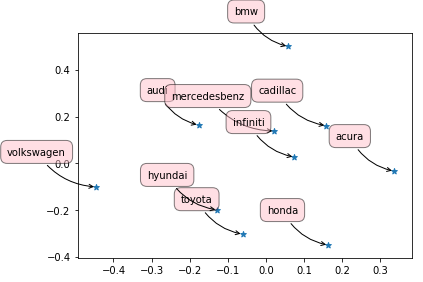

In [20]:
# Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/df2
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = '*'
    )
for label, x, y in zip(top_10_brands_list, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.65', fc = 'pink', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.25'))

plt.show()

## Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

Audi: For Audi, Mercedesbenz has the largest lift among all other brands. This means Audi and Mercedesbenz are close competitors in this market, and customers are more likely to choose Mercedesbenz if they considered about buying Audi but did not buy. Hyundai has the lowest lift, therefore, customers who considered about Audi will less likely consider about Hyundai.

Mercedesbenz: As for Mercedesben, cadillac has the biggest lift amount all its competitors. These two brands are extremely similar and are very hard to be differentiated for customers. Another big competitor of Mercedesbenz is Infiniti, which has the second biggest lift in the chart. Since Infiniti has more entry-level models, budget-efficient customers may prefer Infiniti to Mercedesbenz. Honda has the lowest lift among all brands. Therefore, customers can easily distinguish Mercedesbenza and Honda, and will not switch between these two brands.

## Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [21]:
comfort = ['luxury', 'room', 'tall', 'leather', 'interior']
console = ['gps', 'navigation', 'nav', 'dashboard', 'monitor']
efficiency = ['efficiency', 'mileage', 'mpg', 'gas', 'efficient']
performance = ['performance', 'hp', 'fwd', 'power', 'horsepower']
safety = ['safety', 'save', 'airbags', 'tire', 'radial']
styling = ['sunroof', 'color', 'paint', 'wheels', 'wheel']
maintenance = ['warranty', 'warranties', 'maintenance', 'repair','service']

In [22]:
allattributes = comfort+console+efficiency+performance+safety+styling+maintenance
allattributes

['luxury',
 'room',
 'tall',
 'leather',
 'interior',
 'gps',
 'navigation',
 'nav',
 'dashboard',
 'monitor',
 'efficiency',
 'mileage',
 'mpg',
 'gas',
 'efficient',
 'performance',
 'hp',
 'fwd',
 'power',
 'horsepower',
 'safety',
 'save',
 'airbags',
 'tire',
 'radial',
 'sunroof',
 'color',
 'paint',
 'wheels',
 'wheel',
 'warranty',
 'warranties',
 'maintenance',
 'repair',
 'service']

In [23]:
car_attribute = pd.DataFrame(allattributes,columns =['Attribute'])
car_attribute['general attribute'] = ''

In [24]:
car_attribute['general attribute'][0:5] = 'comfort'
car_attribute['general attribute'][5:10] = 'console'
car_attribute['general attribute'][10:15] = 'efficiency'
car_attribute['general attribute'][15:20] = 'performance'
car_attribute['general attribute'][20:25] = 'safety'
car_attribute['general attribute'][25:30] = 'styling'
car_attribute['general attribute'][30:35] = 'maintenance'

In [25]:
car_attribute.head()

,Attribute,general attribute
0,luxury,comfort
1,room,comfort
2,tall,comfort
3,leather,comfort
4,interior,comfort


In [26]:
def word_to_attributes(s):
    s = " ".join(str(x) for x in s)
    for i in car_attribute.index.values:
        s = s.replace(car_attribute["Attribute"][i].lower(),car_attribute["general attribute"][i].lower())
    return s

copy_comments['comments_attributes_replace'] = copy_comments['final_list'].apply(word_to_attributes)

In [27]:
count = []
for i in range(len(copy_comments)):
    count+=copy_comments['comments_attributes_replace'][i]
attr_freq = nltk.FreqDist(count)
attributes_unique = car_attribute["general attribute"].drop_duplicates().tolist()

top_words = word_freq.most_common(3000)
top_attributes = []
for (key, items) in top_words:
    if key in attributes_unique:
        attribute_counts = (key,items)
        top_attributes.append(attribute_counts)

In [28]:
top_5_attributes_counts = top_attributes[:5]
print ('Below are the top 5 attributes along with their frequencies\n' , top_5_attributes_counts)

Below are the top 5 attributes along with their frequencies
 [('performance', 303), ('maintenance', 102), ('styling', 54), ('safety', 48), ('console', 15)]


In [29]:
top_5_attributes =[]
for attribute, count in top_5_attributes_counts:
    top_5_attributes.append(attribute)

In [30]:
top_5_attributes

['performance', 'maintenance', 'styling', 'safety', 'console']

In [31]:
attributes_df = pd.DataFrame(columns = top_5_attributes)

def attribute_mentioned(item):
    if attribute in item:
        return 1
    else:
        return 0
      
for attribute in top_5_attributes:
    attributes_df[attribute] = copy_comments['comments_attributes_replace'].apply(attribute_mentioned)

In [32]:
attributes_df.head()

,performance,maintenance,styling,safety,console
0,0,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,0,0,0
4,0,1,0,0,0


In [33]:
df3=pd.DataFrame(columns = top_5_attributes)
top_5_brands = top_10_brands_list[:5]
for i in range(len(top_5_brands)):
    new_list = []
    for j in range(len(top_5_attributes)):
        numerator = ((df[top_5_brands[i]] + attributes_df[top_5_attributes[j]]) > 1).sum()
        denominator = df[top_5_brands[i]].sum()*attributes_df[top_5_attributes[j]].sum()
        lift_brand_attributes = numerator*len(attributes_df)/denominator
        df3.loc[top_5_brands[i],top_5_attributes[j]] = lift_brand_attributes

print ('Below are the lift ratios between top 5 brands and top 5 attributes \n')
df3

Below are the lift ratios between top 5 brands and top 5 attributes 



,performance,maintenance,styling,safety,console
bmw,1.71957,1.57125,1.86154,1.30651,1.8691
audi,1.94224,1.69965,2.13187,1.55805,2.58308
acura,1.67756,1.33391,2.22063,1.44008,1.91998
honda,1.72658,1.3454,2.138,1.86891,2.83926
volkswagen,1.62462,1.88124,1.52331,1.55664,1.8194


## Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 

#### BMW:
Safety is comparatively very low as compared to all other brands and none of the lift ratios among these five attributes really stands out. This could be translated as BMW’s car doesn’t have a strong competitive advantage. The car made by BMW might be too balanced so BMW should choose any one of attribute and heavily invest in.

#### Audi:
People usually associate styling, console, and performance with Audi’s vehicles which is good for its brand image. But the problem is the lift ratios of Audi are similar to that of Acura, making people hard to differentiate Audi form Acura. However, since these two brands have significant different price tags, it will not be a big issue. Although Audi already out-performs BMW in every attribute, it is better to spend more on the console to enlarge their lead in this field to make it the leading player.

#### Acura: 
People associate styling the most with Acura compare to other brands, therefore, Acura should invest more on advertising on the styling of its cars. On the other hand, Acura has the lowest lift of performance and maintenance among all brands, which might the primary reason people won’t switch from Audi or BMW to Acura. Therefore, in order to attract more customers, especially customers who value both styling and performance, Acura should make its car more powerful and make the customer aware of its change.

#### Honda:
Have the strongest association with safety (lift of safety = 1.89) and console (lift of console = 2.84) among all brands. Therefore, safety and console should be the focus on advertising, because no other brands can be a strong competitor in these attributes. What’s more, the console of Honda is very high, while the second brand which has the closest lift is Audi (lift of console = 2.58). But Audi’s price is higher than Honda and focus on customers who have different purchase powers. To conclude, the best selling point of Honda should be the console.

#### Volkswagen: 
Should focus more on styling and safety as people don’t associate styling very highly with Volkswagen.  People associate maintenance with Volkswagen so they can continue focusing on advertising in that area.


In [34]:
# aspire=['used', 'want', 'love', 'like', 'desire', 'hope', 'dream']

aspire=['dreaming','like','dreamed','wanted','love','dream car','future car','dream of','dream to','wish','best','love to have','want','wanted','dreamy']

In [35]:
aspirational_att = pd.DataFrame(aspire,columns =['asp_attribute'])
aspirational_att['general_asp_attribute'] = ''

In [36]:
aspirational_att['general_asp_attribute'][:] = 'aspire'
aspirational_att


,asp_attribute,general_asp_attribute
0,dreaming,aspire
1,like,aspire
2,dreamed,aspire
3,wanted,aspire
4,love,aspire
5,dream car,aspire
6,future car,aspire
7,dream of,aspire
8,dream to,aspire
9,wish,aspire


In [37]:
def word_to_asp_att(s):
    s = " ".join(str(x) for x in s)
    for i in aspirational_att.index.values:
        s = s.replace(aspirational_att["asp_attribute"][i].lower(),aspirational_att["general_asp_attribute"][i].lower())
    return s

copy_comments['comments_asp_attrib'] = copy_comments['final_list'].apply(word_to_asp_att)

In [38]:
copy_comments.head()

,index,Unnamed: 0,Date,user_id,comments,comments_clean,model_to_brand,tokenize_comments,final_list,comments_attributes_replace,comments_asp_attrib
0,0,0,"August 18, 2019 8:19PM",andres3,The leather is definitely more Audi-like tha...,the leather is definitely more audilike than j...,the leather is definitely more audilike than v...,"[definitely, than, leather, volkswagenlike, mo...","[definitely, leather, volkswagenlike, audilike]",definitely comfort volkswagenlike audilike,definitely leather volkswagenaspire audiaspire
1,1,1,"August 18, 2019 8:45PM",dino001,It just made my next car list. Looks very much...,it just made my next car list looks very much ...,it just made my next car ltoyota looks very mu...,"[warranty, on, good, find, volkswagen, there, ...","[warranty, good, find, volkswagen, 6year, back...",maintenance good find volkswagen 6year back es...,warranty good find volkswagen 6year back espec...
2,2,2,"August 18, 2019 8:55PM",Michaell,The 6/72 warranty is over with the 2019 model...,the 672 warranty is over with the 2019 model year,the 672 warranty is over with the 2019 model year,"[warranty, year, model, over, 2019, 672, is, w...","[warranty, year, model, 2019, 672]",maintenance year model 2019 672,warranty year model 2019 672
3,3,3,"August 18, 2019 9:09PM",dino001,You mean 2019 is the last year? That’s a bumme...,you mean 2019 is the last year that’s a bummer...,you mean 2019 is the last year that’s a bummer...,"[’, s, word, 336, wonder, so, are, on, far, th...","[’, word, 336, wonder, far, last, models, stan...",’ word 336 wonder far last models standard web...,’ word 336 wonder far last models standard web...
4,4,4,"August 18, 2019 10:17PM",sda,"4 yr/50k, same as Audi. From what I read deal...",4 yr50k same as audi from what i read dealers ...,4 yr50k same as audi from what i read dealers ...,"[warranty, so, selling, same, an, difficult, t...","[warranty, selling, difficult, toyotad, read, ...",maintenance selling difficult toyotad read dea...,warranty selling difficult toyotad read dealer...


In [39]:
count = []
for i in range(len(copy_comments)):
    count+=copy_comments['comments_asp_attrib'][i]
asp_attr_freq = nltk.FreqDist(count)
asp_att_unique = aspirational_att["general_asp_attribute"].drop_duplicates().tolist()

top_asp_words = word_freq.most_common(7000)
top_asp_att = []
for (key, items) in top_asp_words:
    if key in asp_att_unique:
        asp_att_counts = (key,items)
#         print(asp_att_counts)
        top_asp_att.append(asp_att_counts)

In [40]:
asp_attributes_df = pd.DataFrame(columns = ['aspiration'])

def asp_attribute_mentioned(item):
    if att in item:
        return 1
    else:
        return 0
      
for att in aspirational_att['general_asp_attribute'].unique():
    asp_attributes_df['aspiration'] = copy_comments['comments_asp_attrib'].apply(asp_attribute_mentioned)
   

In [41]:
asp_attributes_df.head()

,aspiration
0,1
1,1
2,0
3,0
4,0


## Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?
* __Most Aspirational Brand__: Audi

* __Analysis__: We put together a group of words related to "Aspire" and performed an analysis similar to that in Task C by finding the lift of the aspire list against our top 5 brands

* __Business Implications__: Audi is already very desired from a styling point of view so they should continue to market heavily in that area while starting to consider improving safety features to further set them apart.

In [42]:
df4=pd.DataFrame(columns = top_asp_att)
top_5_brands = top_10_brands_list[:5]

for i in range(len(top_5_brands)):
    new_list = []
    numerator = ((df[top_5_brands[i]] + asp_attributes_df['aspiration']) > 1).sum()
    denominator = df[top_5_brands[i]].sum()*asp_attributes_df['aspiration'].sum()
    asp_lift_brand_attributes = numerator*len(asp_attributes_df)/denominator
    df4.loc[top_5_brands[i],'aspiration'] = asp_lift_brand_attributes
print ('Below are the lift ratios between top 5 brands and aspiration \n')
df4.head()

Below are the lift ratios between top 5 brands and aspiration 



,"(aspire, 9)",aspiration
bmw,NaN,1.386167
audi,NaN,1.617081
acura,NaN,1.571036
honda,NaN,1.543578
volkswagen,NaN,1.404690
